# Modèle 1: Sans classe 0

In [2]:
# Cellule 1: Importation des bibliothèques et définition des paramètres
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




In [3]:
# Chemins et paramètres
data_dir = "/kaggle/input/data-train-unanimes-finales"  # Dossier contenant les images
csv_path = "/kaggle/input/annotations-unanimes-finales/annotations_unanimes.csv"  # CSV avec colonnes: id, espece
target_size = (224,224)
batch_size = 4
num_epochs = 50

In [4]:
# Cellule 2: Chargement du CSV et préparation de la DataFrame
df = pd.read_csv(csv_path)
# Créer une colonne "filename" en ajoutant ".jpg" au champ "id"
df["filename"] = df["id"] + ".jpg"
# Convertir la colonne "espece" en chaîne de caractères (pour le générateur)
df["espece"] = df["espece"].astype(str)



In [5]:
# Cellule 3: Split train/validation et création des générateurs d'images

from sklearn.model_selection import train_test_split

# Filtrer les données pour exclure la classe 0
df_filtered = df[df["espece"] != "0"]
df=df_filtered
# Séparation en 80% train / 20% validation, en stratifiant sur "espece"
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["espece"])

# Data augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    brightness_range=(0.8, 1.2),
    zoom_range=(1.0, 1.2)
)
# Pour la validation, on se contente du rescale
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col="filename",
    y_col="espece",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col="filename",
    y_col="espece",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Nombre de classes :", num_classes)


Found 706 validated image filenames belonging to 8 classes.
Found 177 validated image filenames belonging to 8 classes.
Nombre de classes : 8


In [6]:
# Cellule 4: Construction du modèle
# Charger EfficientNetB0 avec les poids ImageNet, sans la tête de classification
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(target_size[0], target_size[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Pour réentraîner toutes les couches, on s'assure que toutes les couches sont entraînables
for layer in base_model.layers:
    layer.trainable = True

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 4,017,796 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
# Cellule 5: Définition du callback F1Macro et entraînement initial

from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import numpy as np

# Callback pour calculer le F1 score macro à la fin de chaque époque
class F1MacroCallback(Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        # Nombre de batches dans le générateur de validation
        steps = len(self.val_generator)
        # Prédire sur l'ensemble du jeu de validation
        preds = self.model.predict(self.val_generator, steps=steps)
        # Convertir les prédictions en indices de classes
        val_predict = np.argmax(preds, axis=1)
        # Récupérer les véritables labels dans le même ordre
        val_true = self.val_generator.classes  
        # Calculer le F1 macro
        f1 = f1_score(val_true, val_predict, average='macro')
        print(f"\nF1 Score Macro (val) = {f1:.4f}")
        logs["val_f1_macro"] = f1

# Instancier le callback F1
f1_callback = F1MacroCallback(val_generator)

# Définir les autres callbacks (EarlyStopping et ModelCheckpoint)
callbacks = [
    EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True, verbose=1),
    f1_callback
]

# Compilation du modèle pour l'entraînement initial
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [10]:
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/stepp - accuracy: 0.41

F1 Score Macro (val) = 0.0254
177/177 ━━━━━━━━━━━━━━━━━━━━ 147s 428ms/step - accuracy: 0.4165 - loss: 1.6492 - val_accuracy: 0.1130 - val_loss: 3.4677 - val_f1_macro: 0.0254
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/stepep - accuracy: 0.5896 

F1 Score Macro (val) = 0.0387
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5897 - loss: 1.1204 - val_accuracy: 0.1186 - val_loss: 4.5404 - val_f1_macro: 0.0387
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/stepep - accuracy: 0.6869 -

F1 Score Macro (val) = 0.3172
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.6870 - loss: 0.8872 - val_accuracy: 0.3616 - val_loss: 3.6933 - val_f1_macro: 0.3172
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/stepep - accuracy: 0.7362 

F1 Score Macro (val) = 0.6850
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7361 - loss: 0.7925 - val_accuracy: 0.7345 - val_loss: 0.6876 - val_f1_macro: 0.6850
Epoch 5/50
45/45 ━━━━━━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


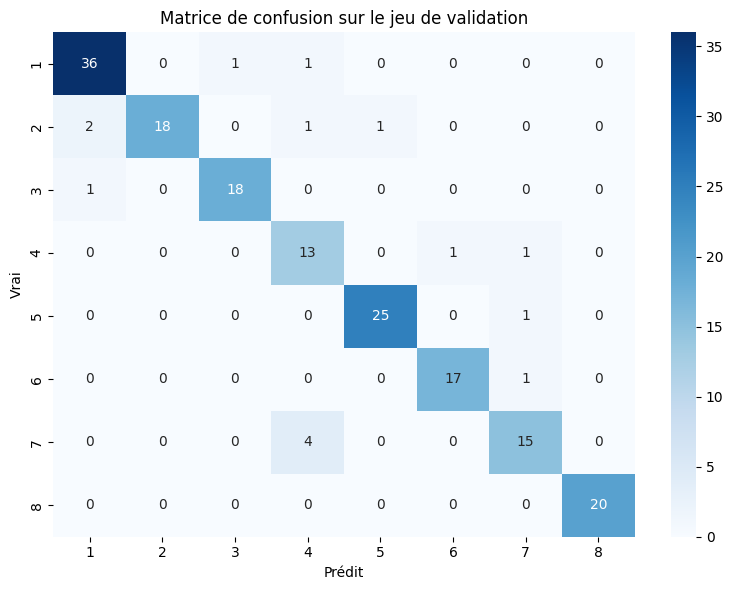

In [15]:
# Calcul des prédictions sur le jeu de validation
predictions = model.predict(val_generator, steps=len(val_generator))
# Convertir les prédictions en indices de classes
val_pred_classes = np.argmax(predictions, axis=1)
# Récupérer les véritables labels dans le même ordre
val_true = val_generator.classes

# Calcul de la matrice de confusion
cm = confusion_matrix(val_true, val_pred_classes)

# Récupérer les noms de classes dans l'ordre (à partir du générateur d'entraînement)
class_labels = sorted(train_generator.class_indices, key=train_generator.class_indices.get)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion sur le jeu de validation")
plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(val_true, val_pred_classes, target_names=class_labels))


## Deuxième modèle discriminant

In [22]:
# Charger le DataFrame original (non filtré)
df_all = pd.read_csv(csv_path)
df_all["filename"] = df_all["id"] + ".jpg"
df_all["espece"] = df_all["espece"].astype(str)

# Préparation des données pour le modèle discriminant
df_disc = df_all.copy()  # Utiliser le DataFrame complet
df_disc["binary_label"] = df_disc["espece"].apply(lambda x: "0" if x == "0" else "others")


In [23]:
# Split train/validation en stratifiant sur le label binaire
from sklearn.model_selection import train_test_split
train_df_disc, val_df_disc = train_test_split(df_disc, test_size=0.2, random_state=42, stratify=df_disc["binary_label"])

# Utilisation des mêmes paramètres de data augmentation et de rescaling
# pour être cohérent avec le premier modèle.
train_datagen_disc = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    brightness_range=(0.8, 1.2),
    zoom_range=(1.0, 1.2)
)
val_datagen_disc = ImageDataGenerator(rescale=1./255)

# Création des générateurs pour le modèle discriminant
train_generator_disc = train_datagen_disc.flow_from_dataframe(
    train_df_disc,
    directory=data_dir,    # Même dossier d'images
    x_col="filename",
    y_col="binary_label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",  # Utilisé pour une classification à 2 classes
    shuffle=True
)

val_generator_disc = val_datagen_disc.flow_from_dataframe(
    val_df_disc,
    directory=data_dir,
    x_col="filename",
    y_col="binary_label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)



Found 1037 validated image filenames belonging to 2 classes.
Found 260 validated image filenames belonging to 2 classes.


In [24]:
# Affichage du nombre de classes (attendu : 2)
num_classes_disc = len(train_generator_disc.class_indices)
print("Nombre de classes (modèle discriminant) :", num_classes_disc)




Nombre de classes (modèle discriminant) : 2


In [25]:
# --- Construction du modèle discriminant ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Charger EfficientNetB0 pré-entraîné sur ImageNet, sans la tête de classification
base_model_disc = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(target_size[0], target_size[1], 3))
x_disc = base_model_disc.output
x_disc = GlobalAveragePooling2D()(x_disc)
x_disc = Dropout(0.5)(x_disc)
# La couche finale doit correspondre à 2 classes ("0" et "others")
predictions_disc = Dense(num_classes_disc, activation="softmax")(x_disc)
model_discriminant = Model(inputs=base_model_disc.input, outputs=predictions_disc)

# Rendre les couches du modèle de base entraînables
for layer in base_model_disc.layers:
    layer.trainable = True

# Afficher le résumé du modèle discriminant
model_discriminant.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [27]:
# Compilation du modèle discriminant
model_discriminant.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Instancier le callback pour le modèle discriminant
f1_callback_disc = F1MacroCallback(val_generator_disc)

# Entraînement du modèle discriminant avec le callback F1Macro
history_disc = model_discriminant.fit(
    train_generator_disc,
    epochs=num_epochs,
    validation_data=val_generator_disc,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
        f1_callback_disc
    ]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 30/260 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.5612 - loss: 0.7080

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Générer les prédictions sur le jeu de validation pour le modèle discriminant
predictions_disc = model_discriminant.predict(val_generator_disc, steps=len(val_generator_disc))
val_pred_classes_disc = np.argmax(predictions_disc, axis=1)
val_true_disc = val_generator_disc.classes

# Calculer la matrice de confusion
cm_disc = confusion_matrix(val_true_disc, val_pred_classes_disc)
# Récupérer l'ordre des classes tel que défini par le générateur
class_labels_disc = sorted(train_generator_disc.class_indices, key=train_generator_disc.class_indices.get)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_disc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels_disc, yticklabels=class_labels_disc)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion pour le modèle discriminant")
plt.tight_layout()
plt.show()

# Afficher un rapport de classification détaillé
print(classification_report(val_true_disc, val_pred_classes_disc, target_names=class_labels_disc))
